In [1]:
import numpy as np
import torch
from torch import nn
#import gym
#import cv2
import copy
import time
import matplotlib.pyplot as plt
#from IPython import display
import seaborn as sns

%matplotlib inline

In [2]:
N_FRAMES = 4

def filter(obs):
    assert(type(obs) == np.ndarray), "The observation must be a numpy array!"

    m = np.mean(obs)
    v = np.var(obs)
    
    obs = (obs - m)/v   
    return obs

def get_stacked_obs(obs, prev_frames):
    if not prev_frames:
        prev_frames = [obs] * (N_FRAMES - 1)
        
    prev_frames.append(obs)
    stacked_frames = np.stack(prev_frames)
    prev_frames = prev_frames[-(N_FRAMES-1):]
    
    return stacked_frames, prev_frames

def preprocess_obs(obs, prev_frames):
    filtered_obs = filter(obs)
    stacked_obs, prev_frames = get_stacked_obs(filtered_obs, prev_frames)
    return stacked_obs, prev_frames

In [3]:
# Original Paper
class DQN(nn.Module):
    def __init__(self, len_state, len_action):
        
        super(DQN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(len_state+len_action,64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Linear(64,1),
            nn.ReLU())
        
    def forward(self, obs):
        q_values = self.layer1(obs)
        q_values = self.layer2(q_values)
        q_values = self.layer3(q_values)
        
        return q_values
    
    def train_on_batch(self, target_model, optimizer,input, obs, acts, rewards, next_obs, terminals, gamma=0.99):

        #тут пока не сделано 
        
        sampler = qmc.LatinHypercube(d=X.shape[1])
        sample = sampler.random(n=5)
        sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
        actions = np.array(sample_scaled)
        next_q_values = []
        for a in actions:
            input = torch.tensor(np.concatenate((next_obs,[a]*4),axis=1)).float() 
            q_value = self.forward(next_obs)
            #q_value = q_value.detach().numpy()
            next_q_values.append(q_value)
        
        #next_q_values = self.forward(next_obs)
        max_next_acts = torch.max(next_q_values, dim=1)[1].detach()
        
        target_next_q_values = target_model.forward(next_obs)
        max_next_q_values = target_next_q_values.gather(index=max_next_acts.view(-1, 1), dim=1)
        max_next_q_values = max_next_q_values.view(-1).detach()
        
        terminal_mods = 1 - terminals
        actual_qs = rewards + terminal_mods * gamma * max_next_q_values
            
        pred_qs = self.forward(obs)
        pred_qs = pred_qs.gather(index=acts.view(-1, 1), dim=1).view(-1)
        
        loss = torch.mean((actual_qs - pred_qs) ** 2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [56]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []
        
    def add_step(self, step_data):
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data = self.data[-self.capacity:]
            
    def sample(self, n):
        n = min(n, len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = np.asarray(self.data, dtype="object")[indices]

        #print(samples[:, 0],list(samples[:, 1])*4)
        input = torch.tensor(np.concatenate((samples[:, 0][0],list(samples[:, 1])*4),axis=1)).float() 
        #print(input)
        
        state_data = torch.tensor(np.stack(samples[:, 0])).float()
        act_data = torch.tensor(np.stack(samples[:, 1])).float()
        reward_data = torch.tensor(np.stack(samples[:, 2])).float()
        next_state_data = torch.tensor(np.stack(samples[:, 3])).float()
        terminal_data = torch.tensor(np.stack(samples[:, 4])).int()
        
        return input, state_data, act_data, reward_data, next_state_data, terminal_data

# DQN Algorithm

<img src='imgs/dqn_algorithm.png' width=80% align='left' />

In [10]:
from environment import Environment
from scipy.stats import qmc

In [12]:
X = np.linspace(-3,3,90).reshape(-1,3)
y = np.sum(np.sin(X),axis=1)

def f(x):
    s = np.sin(x).shape
    if len(s)>1:
        return np.sum(np.sin(x),axis=1)
    else:
        return [np.sum(np.sin(x))]

l_bounds = [-3,-3,-3]
u_bounds = [3,3,3]

env = Environment(X = X,y = y,l_bounds = l_bounds,u_bounds = u_bounds, func = f, model = 'NN',model_param = {'d':3,'nb_nodes':40,'nb_layers':4})

state = env.Reset()

In [16]:
#n_episodes = 10000
n_episodes = 100
max_steps = 100
er_capacity = 15 # 1m in paper
#n_acts = env.action_space.n # 0: no-op, 1: start game, 2: right, 3: left
train_batch_size = 32
learning_rate = 2.5e-4
update_freq = 4
print_freq = 5
frame_skip = 3
n_anneal_steps = 1e5 # Anneal over 1m steps in paper
target_update_delay = 10 # How many timesteps in between target model update
epsilon = lambda step: np.clip(1 - 0.9 * (step/n_anneal_steps), 0.1, 1) # Anneal over 1m steps in paper, 100k here

In [54]:
er = ExperienceReplay(er_capacity)
model = DQN(len(state),X.shape[1])

target_model = copy.deepcopy(model)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, eps=1e-6)
all_rewards = []
global_step = 0

for episode in range(n_episodes):
    prev_frames = []
    obs, prev_frames = preprocess_obs(env.Reset(), prev_frames)
    
    episode_reward = 0
    step = 0
    while step < max_steps:

        ### Enact a step ###
        if np.random.rand() < epsilon(global_step):
            sampler = qmc.LatinHypercube(d=X.shape[1])
            sample = sampler.random(n=1)
            sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
            act = np.array(sample_scaled)[0]
            #act = np.random.choice(range(n_acts))
        else:   
            sampler = qmc.LatinHypercube(d=X.shape[1])
            sample = sampler.random(n=5)
            sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
            acts = np.array(sample_scaled)
            q_values = []
            for a in acts:
                input = torch.tensor(np.concatenate((obs,[a]*4),axis=1)).float() 
                q_value = model(input)[0]
                q_value = q_value.detach().numpy()
                q_values.append(q_value)
                
            act = acts[np.argmax(q_values)]
        print(act)
        
        cumulative_reward = 0
        for _ in range(frame_skip):
            next_obs, reward, done, _ = env.Step(act)
            cumulative_reward += reward
            current_reward = reward
            if done or step >= max_steps:
                break
        #episode_reward += cumulative_reward
        #reward = format_reward(cumulative_reward)
        reward = current_reward

        next_obs, prev_frames = preprocess_obs(next_obs, prev_frames)
        er.add_step([obs, act, reward, next_obs, int(done)])
        obs = next_obs
        
        ### Train on a minibatch ###
        
        if global_step % update_freq == 0:
            input, obs_data, act_data, reward_data, next_obs_data, terminal_data = er.sample(train_batch_size)
            #print(obs_data, act_data)
            model.train_on_batch(target_model, optimizer, input, obs_data, act_data,
                                 reward_data, next_obs_data, terminal_data)
        
        ### Update target network ###
        
        if global_step and global_step % target_update_delay == 0:
            target_model = copy.deepcopy(model)
        
        ### Finish the step ###
        
        step += 1
        global_step += 1
        
        if done:
            break

    all_rewards.append(episode_reward)
    
    if episode % print_freq == 0:
        print('Episode #{} | Step #{} | Epsilon {:.2f} | Avg. Reward {:.2f}'.format(
            episode, global_step, epsilon(global_step), np.mean(all_rewards[-print_freq:])))

[ 0.98165751 -2.74413576 -1.45612695]
[-0.99324214 -0.10862727 -2.26533127 ...  0.98165751 -2.74413576
 -1.45612695]
[array([[-0.60470466, -1.09326215, -1.31471361, ...,  1.68070455,
          1.72014803,  1.7595915 ],
        [-0.60470466, -1.09326215, -1.31471361, ...,  1.68070455,
          1.72014803,  1.7595915 ],
        [-0.60470466, -1.09326215, -1.31471361, ...,  1.68070455,
          1.72014803,  1.7595915 ],
        [-0.60470466, -1.09326215, -1.31471361, ...,  1.68070455,
          1.72014803,  1.7595915 ]])                             ] [array([ 0.98165751, -2.74413576, -1.45612695]), array([ 0.98165751, -2.74413576, -1.45612695]), array([ 0.98165751, -2.74413576, -1.45612695]), array([ 0.98165751, -2.74413576, -1.45612695])]
tensor([[-0.6047, -1.0933, -1.3147,  ...,  0.9817, -2.7441, -1.4561],
        [-0.6047, -1.0933, -1.3147,  ...,  0.9817, -2.7441, -1.4561],
        [-0.6047, -1.0933, -1.3147,  ...,  0.9817, -2.7441, -1.4561],
        [-0.6047, -1.0933, -1.3147,  ...,

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x1030 and 1033x64)

In [10]:
prev_frames = []
obs, prev_frames = preprocess_obs(env.reset(), prev_frames)

for step in range(max_steps):
    if np.random.rand() < 0.05:
        act = np.random.choice(range(n_acts))
    else:
        obs_tensor = torch.tensor([obs]).float().cuda()
        q_values = model(obs_tensor)[0]
        q_values = q_values.cpu().detach().numpy()
        act = np.argmax(q_values)

    for _ in range(frame_skip):
        next_obs, reward, done, _ = env.step(act)
        if done or step >= max_steps:
            break
            
        env.render()
        time.sleep(0.05)
        
    if done:
        break

    obs, prev_frames = preprocess_obs(next_obs, prev_frames)

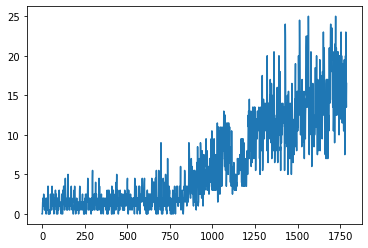

In [14]:
smoothed_rewards = []
smooth_window = 1
for i in range(smooth_window, len(all_rewards)-smooth_window):
    smoothed_rewards.append(np.mean(all_rewards[i-smooth_window:i+smooth_window]))
    
plt.plot(range(len(smoothed_rewards)), smoothed_rewards)

In [ ]:
torch.save(model, 'models/double_dqn_breakout_r14.pt')